In [ ]:
# Import library standar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import utility functions
import joblib

# Import tools dari scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import model dari scikit-learn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Import model XGBoost
from xgboost import XGBRegressor

# Import metrik evaluasi
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [10]:
# Load data
data = pd.read_csv('../01_Data/data_california_house_prepared.csv')

In [11]:
# Pisahkan fitur dan target
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
numeric_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                    'total_bedrooms', 'population', 'households', 'median_income']
categorical_features = ['ocean_proximity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [ ]:
# Daftar model
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Fungsi untuk menghitung MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Dictionary untuk menyimpan hasil evaluasi
metrics_results = {
    'Model': [],
    'R-squared': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'MAPE (%)': []
}

# Tempat Menyimpan Best Model
best_r2 = -float('inf')
best_model = None
best_model_name = ""

# Evaluasi setiap model
for name, regressor in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', regressor)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Hitung metrik
    r2 = r2_score(y_test, y_pred)
    
    # Update model terbaik
    if r2 > best_r2:
        best_r2 = r2
        best_model = pipeline
        best_model_name = name
    
    # Hitung semua metrik
    metrics_results['Model'].append(name)
    metrics_results['R-squared'].append(r2_score(y_test, y_pred))
    metrics_results['MAE'].append(mean_absolute_error(y_test, y_pred))
    metrics_results['MSE'].append(mean_squared_error(y_test, y_pred))
    metrics_results['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    metrics_results['MAPE (%)'].append(mean_absolute_percentage_error(y_test, y_pred))

d:\PurwadhikaBackup\capstoneproject\modultiga\california_housing_price_prediction\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.595e+12, tolerance: 1.537e+10
  model = cd_fast.enet_coordinate_descent(



Hasil Evaluasi Model:
               Model  R-squared        MAE           MSE       RMSE  MAPE (%)
0  Linear Regression      0.637  49837.785  4.848118e+09  69628.428    29.023
1   Ridge Regression      0.637  49834.902  4.847546e+09  69624.324    29.019
2   Lasso Regression      0.637  49837.760  4.848108e+09  69628.355    29.023
3      Decision Tree      0.613  45116.621  5.172154e+09  71917.687    24.639
4      Random Forest      0.813  32608.320  2.503304e+09  50033.025    18.790
5            XGBoost      0.818  32728.489  2.429630e+09  49291.279    18.541


C:\Users\mirur\AppData\Local\Temp\ipykernel_11968\2608435674.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')
C:\Users\mirur\AppData\Local\Temp\ipykernel_11968\2608435674.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')
C:\Users\mirur\AppData\Local\Temp\ipykernel_11968\2608435674.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')
C:\Users\mirur\AppData\Local\Temp\

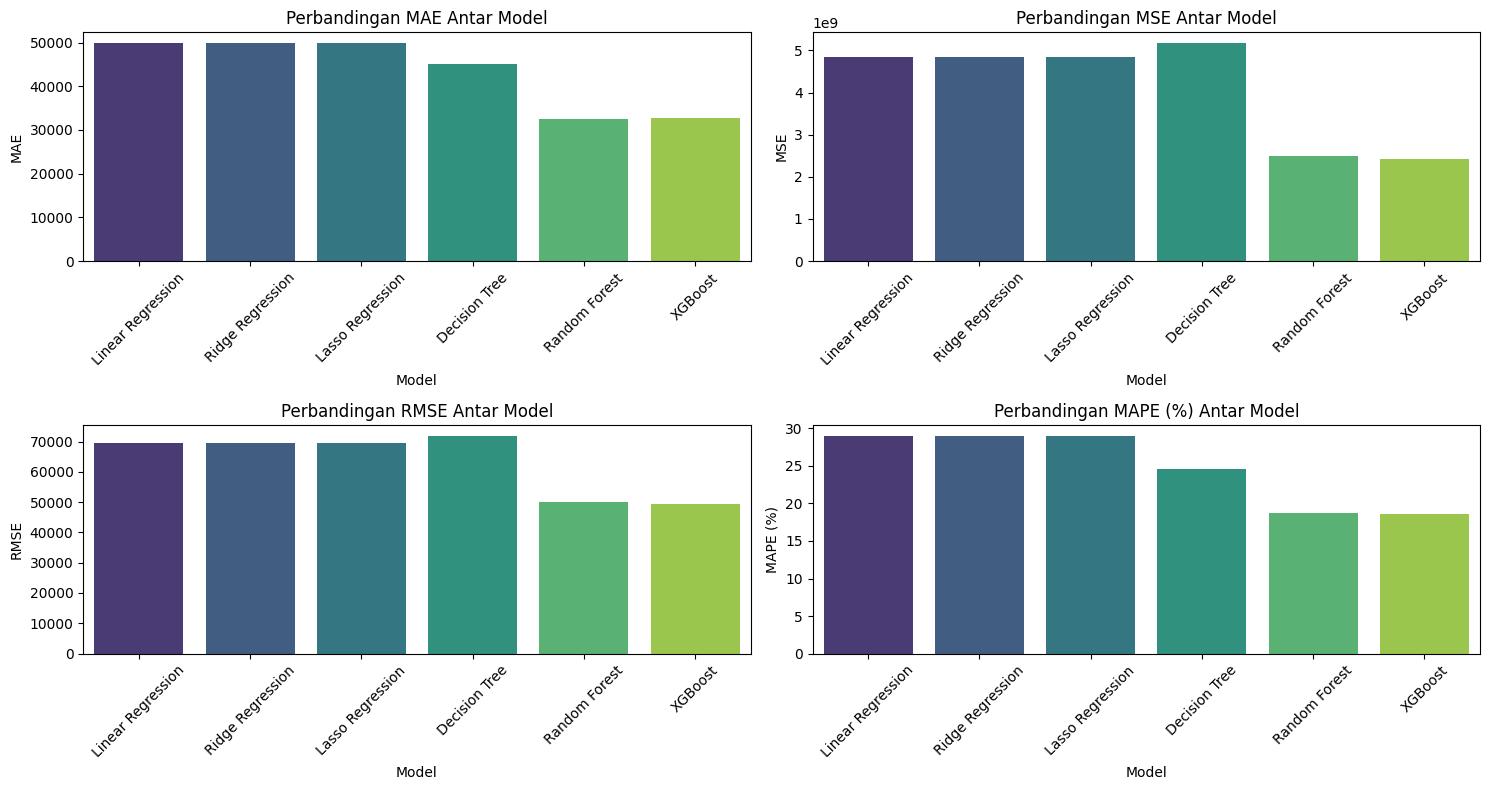

C:\Users\mirur\AppData\Local\Temp\ipykernel_11968\2608435674.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics_df, x='Model', y='R-squared', palette='coolwarm')


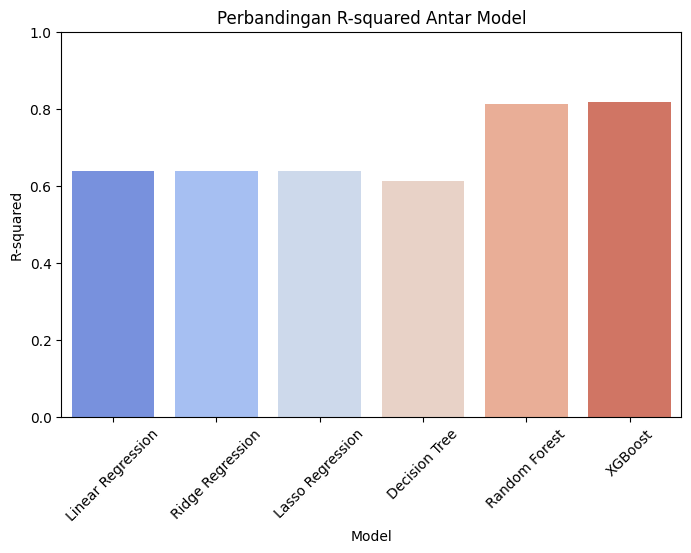

In [ ]:
# Tabel hasil metrik
metrics_df = pd.DataFrame(metrics_results)
print("\nHasil Evaluasi Model:")
print(metrics_df.round(3))
print(f"Model terbaik: {best_model_name} dengan R-squared: {best_r2:.3f}")

# Visualisasi perbandingan metrik
plt.figure(figsize=(15, 8))

# Plot MAE, MSE, RMSE
metrics_to_plot = ['MAE', 'MSE', 'RMSE', 'MAPE (%)']
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.barplot(data=metrics_df, x='Model', y=metric, palette='viridis')
    plt.title(f'Perbandingan {metric} Antar Model')
    plt.xticks(rotation=45)
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

# Plot R-squared terpisah (skala berbeda)
plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Model', y='R-squared', palette='coolwarm')
plt.title('Perbandingan R-squared Antar Model')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # R-squared berkisar 0-1
plt.show()


In [ ]:
# Simpan model terbaik
joblib.dump(best_model, '../03_Model/best_model.pkl')